In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from typing import Literal, Tuple
from contextlib import contextmanager
import matplotlib.pyplot as plt

import random
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, RenyiELBO, JitTrace_ELBO
from pyro.optim import ClippedAdam
from pyro.infer.autoguide import AutoDiagonalNormal, AutoIAFNormal, AutoLowRankMultivariateNormal
from pyro.infer import Predictive



In [2]:
def get_raw_data(path: str, occupation_type: Literal["lsoa", "msoa", "borough"]) -> gpd.GeoDataFrame:
    if occupation_type not in ["lsoa", "msoa", "borough"]:
        raise ValueError("occupation_type must be one of 'lsoa', 'msoa', or 'borough'")
    if occupation_type == "lsoa":
        return gpd.read_parquet(path).rename(columns={
            'LSOA code (2021)': 'occupation', 'date': 'period',
            'Burglaries amount': 'burglaries'
        })
    elif occupation_type == "msoa":
        pass
    elif occupation_type == "borough":
        pass

gdf = get_raw_data("merged_data.parquet", "lsoa")


In [3]:

def downcast_numeric(df: pd.DataFrame) -> pd.DataFrame:
    # 1. downcast integers
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = (
        df[int_cols]
        .apply(pd.to_numeric, downcast='integer')
    )
    
    # 2. downcast floats
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = (
        df[float_cols]
        .apply(pd.to_numeric, downcast='float')
    )
    return df


def convert_occupation_to_idx(gdf: gpd.GeoDataFrame) -> Tuple[gpd.GeoDataFrame, dict, dict]:
    """
    Convert occupation names to indices in the GeoDataFrame.
    """
    if "occupation" not in gdf.columns:
        raise ValueError("GeoDataFrame must contain 'occupation' column")
    
    _, uniques = pd.factorize(gdf["occupation"], sort=False)
    name_to_code = {name: code for code, name in enumerate(uniques)}
    code_to_name = dict(enumerate(uniques))

    return gdf.assign(
        occupation_idx=gdf["occupation"].map(name_to_code)
    ).drop(columns=["occupation"]).pipe(downcast_numeric), name_to_code, code_to_name


gdf, name_to_code, code_to_name = convert_occupation_to_idx(gdf)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 858968 entries, 0 to 858967
Data columns (total 63 columns):
 #   Column                                                                         Non-Null Count   Dtype         
---  ------                                                                         --------------   -----         
 0   period                                                                         858968 non-null  datetime64[ns]
 1   Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)            858968 non-null  float32       
 2   Income Rank (where 1 is most deprived)                                         858968 non-null  float32       
 3   Employment Rank (where 1 is most deprived)                                     858968 non-null  float32       
 4   Education, Skills and Training Rank (where 1 is most deprived)                 858968 non-null  float32       
 5   Health Deprivation and Disability Rank (where 1 is most deprived

In [4]:
def get_static_and_dynamic_cols(gdf: gpd.GeoDataFrame) -> Tuple[list, list]:
    """
    Get static and dynamic columns from the GeoDataFrame.
    """
    other_cols = gdf.columns.difference(["occupation_idx", "period", "burglaries", "geometry"])
    
    nuniques_per_occ = gdf.groupby("occupation_idx")[other_cols].nunique()
    max_nunique = nuniques_per_occ.max()
    
    return (max_nunique[max_nunique == 1].index.tolist(),
            max_nunique[max_nunique > 1].index.tolist())


static, dynamic = get_static_and_dynamic_cols(gdf)

In [5]:

@contextmanager
def detect_new_columns(df):
    """
    Context manager that yields a list which will be populated
    with any column names added to `df` inside the `with` block,
    using pandas’ Index.difference rather than Python sets.
    """
    before_idx = df.columns.copy()  # this is a pandas Index
    new_cols = []
    
    try:
        yield new_cols
    finally:
        new_cols.extend(
            df.columns.difference(before_idx).tolist()
        )


In [6]:
with detect_new_columns(gdf) as time_features:
    t0 = gdf['period'].min()
    # convert each period to the number of months since t0
    time_idx = (
        (gdf['period'].dt.year  - t0.year) * 12
    + (gdf['period'].dt.month - t0.month)
    )
    # center & scale
    gdf['time_s'] = (time_idx - time_idx.mean()) / time_idx.std()

In [7]:
with detect_new_columns(gdf) as seasonal_features:
    gdf['month_sin'] = np.sin(2*np.pi*gdf['period'].dt.month/12).astype("float32")
    gdf['month_cos'] = np.cos(2*np.pi*gdf['period'].dt.month/12).astype("float32")

    lockdown_start = pd.Timestamp("2020-03-23") 
    lockdown_cutoff = pd.Timestamp("2020-03-01")

    restrictions_end = pd.Timestamp("2022-02-24")
    post_corona_start = restrictions_end + pd.Timedelta(days=1)

    gdf["during_corona"] = (
        (gdf["period"] >= lockdown_cutoff) &
        (gdf["period"] <= restrictions_end)
    ).astype("int8")
    gdf["post_corona"] = (gdf["period"] >= post_corona_start).astype("int8")

In [8]:
with detect_new_columns(gdf) as temporal_features:
    gdf['lag_1']  = gdf.groupby('occupation_idx', observed=True)['burglaries'].shift(1)
    gdf['lag_2']  = gdf.groupby('occupation_idx', observed=True)['burglaries'].shift(2)
    gdf['lag_3']  = gdf.groupby('occupation_idx', observed=True)['burglaries'].shift(3)
    gdf['lag_4'] = gdf.groupby('occupation_idx', observed=True)['burglaries'].shift(12)

In [9]:
def create_static_spatial_features(gdf: gpd.GeoDataFrame) -> Tuple[gpd.GeoDataFrame, dict[int, list[int]]]:
    # 1a. Keep only one geometry per occupation_idx (drop duplicate footprints).
    unique_geom = (
        gdf[["occupation_idx", "geometry"]]
        .drop_duplicates(subset=["occupation_idx"])
        .reset_index(drop=True)
    )

    # 1b. Apply buffer(0) to clean any invalid polygons (slivers, self-intersections, etc.).
    unique_geom["geometry"] = unique_geom["geometry"].buffer(0)

    # 1c. Turn it into a proper GeoDataFrame and copy the CRS from gdf_time.
    unique_geom = gpd.GeoDataFrame(
        unique_geom[["occupation_idx", "geometry"]],
        geometry="geometry",
        crs=gdf.crs
    )

    # 1e. Compute each footprint’s area (in the projected CRS units, e.g. m²).
    unique_geom["area"] = unique_geom.geometry.area

    # 1f. Make occupation_idx the index, so that building a spatial index yields 
    #     neighbors keyed by occupation_idx directly.
    unique_geom = unique_geom.set_index("occupation_idx")

    # 2a. Build the spatial index (R-tree) on the buffered geometries:
    sindex = unique_geom.sindex

    # 2b. For each occupation_idx, find all occupation_idx neighbors that touch it:
    neighbor_dict = {}  # will map: occupation_idx → [neighbor_occ1, neighbor_occ2, ...]

    for occ_i, geom_i in unique_geom.geometry.items():
        # 2b.1. Bounding‐box candidates (very fast filter):
        possible_matches = list(sindex.intersection(geom_i.bounds))
        # 2b.2. Keep only those that truly touch (and drop itself):
        actual_neighbors = [
            occ_j
            for occ_j in possible_matches
            if (occ_j != occ_i and geom_i.touches(unique_geom.geometry.loc[occ_j]))
        ]
        neighbor_dict[occ_i] = actual_neighbors

    # Now neighbor_dict[101] might look like [102, 103], etc.

    unique_geom["n_neighbors"] = unique_geom.index.map(lambda i: len(neighbor_dict[i]))
    shared_lengths = []

    for occ_i, geom_i in unique_geom.geometry.items():
        total_len = 0.0
        for occ_j in neighbor_dict[occ_i]:
            shared_line = geom_i.intersection(unique_geom.geometry.loc[occ_j])
            total_len += shared_line.length
        shared_lengths.append(total_len)

    unique_geom["shared_length"] = shared_lengths
        # Prepare a small DataFrame of static attributes:
    static_cols = unique_geom[["area", "n_neighbors", "shared_length"]]

    # Merge onto gdf_time by occupation_idx:
    return static_cols.reset_index().set_index("occupation_idx"), neighbor_dict

In [10]:
with detect_new_columns(gdf) as static_spatial:
    static_cols, neighbor_dict = create_static_spatial_features(gdf)
    
    gdf["area"] = gdf["occupation_idx"].map(static_cols["area"])
    gdf["n_neighbors"] = gdf["occupation_idx"].map(static_cols["n_neighbors"])
    gdf["shared_length"] = gdf["occupation_idx"].map(static_cols["shared_length"])

static.extend(static_spatial)

In [11]:
def create_neighbour_map(neighbor_dict: dict[int, list[int]]) -> pd.DataFrame:
    pairs = []
    for occ_i, neighs in neighbor_dict.items():
        pairs.extend((occ_i, occ_j) for occ_j in neighs)
    return pd.DataFrame(pairs, columns=["occupation_idx", "neighbor_idx"])


def create_dynamic_spatial_features(gdf: gpd.GeoDataFrame,
                                    neighbor_dict: dict[int, list[int]]) -> pd.DataFrame:
    df_neighbors = (
        gdf[["occupation_idx", "time_s", "lag_1"]]
        .rename(columns={
            "occupation_idx": "neighbor_idx",
            "lag_1":          "lag1_neighbor"
        })
    )

    df_base = gdf[["occupation_idx", "time_s"]].drop_duplicates()


    df_occ_neigh = pd.merge(
        df_base,
        create_neighbour_map(neighbor_dict),
        on="occupation_idx",
        how="left"
    )


    df_occ_neigh = pd.merge(
        df_occ_neigh,
        df_neighbors,               # has neighbor_idx | time_s | lag1_neighbor
        on=["neighbor_idx", "time_s"],
        how="left"
    )


    df_occ_neigh = df_occ_neigh.dropna(subset=["neighbor_idx", "lag1_neighbor"])


    return df_occ_neigh.groupby(["occupation_idx", "time_s"])["lag1_neighbor"].agg(
        lag1_sum_neighbors    = "sum",
        lag1_mean_neighbors   = "mean",
        lag1_median_neighbors = "median"
    ).reset_index()

In [12]:
with detect_new_columns(gdf) as dynamic_spatial:
    # Pretty, but runs by assumption that they are indexed correctly
    # Meaning that they are sorted first by occupation_idx, and then time_s
    df = create_dynamic_spatial_features(gdf, neighbor_dict)
    gdf["lag1_sum_neighbors"] = df["lag1_sum_neighbors"].fillna(0)
    gdf["lag1_mean_neighbors"] = df["lag1_mean_neighbors"].fillna(0)
    gdf["lag1_median_neighbors"] = df["lag1_median_neighbors"].fillna(0) 

In [13]:
matrix = gdf.dropna().drop(columns=["geometry", "period"]).pipe(downcast_numeric)
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 794394 entries, 12 to 853973
Data columns (total 76 columns):
 #   Column                                                                         Non-Null Count   Dtype  
---  ------                                                                         --------------   -----  
 0   Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)            794394 non-null  float32
 1   Income Rank (where 1 is most deprived)                                         794394 non-null  float32
 2   Employment Rank (where 1 is most deprived)                                     794394 non-null  float32
 3   Education, Skills and Training Rank (where 1 is most deprived)                 794394 non-null  float32
 4   Health Deprivation and Disability Rank (where 1 is most deprived)              794394 non-null  float32
 5   Crime Rank (where 1 is most deprived)                                          794394 non-null  float32
 6   Barriers to Hous

# Training the model

# Split the data into training and testing

In [14]:
def single_out_last(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the DataFrame into training and test sets.
    The last month is used for testing.
    """
    train = df[df['time_s'] < df['time_s'].max()].copy()
    test = df[df['time_s'] == df['time_s'].max()].copy()
    
    return train, test


matrix, next_month = single_out_last(matrix)

In [15]:
def setup_reproducibility(seed: int = 0) -> torch.device:
    """
    Configure all random seeds and deterministic settings for PyTorch and Pyro,
    then return the chosen device (CPU or CUDA).
    """
    # 1) Seed Python, NumPy, and Torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # 2) Force deterministic CUDA kernels (if using GPU)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # 3) Clear Pyro’s parameter store and seed Pyro
    pyro.clear_param_store()
    pyro.set_rng_seed(seed)

    # 4) Choose device and set it as default
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.set_default_device(device)
    return device


device = setup_reproducibility(42)

In [16]:
def load_and_prepare(
    df,
    static_cols,
    dynamic_cols,
    seasonal_cols,
    time_trend_cols,
    temporal_cols,
    spatial_cols,
):
    """
    Load DataFrame `df` and split its feature columns into five groups:
      - static_cols: features constant per LSOA
      - dynamic_cols: features varying per LSOA & time
      - seasonal_cols: cyclic features (e.g., month indicators)
      - time_trend_cols: features representing global time trend
      - temporal_cols: other time-based features (e.g., day-of-week)
      - spatial_cols: features based on spatial relationships
    Returns a dict with five tensors (X_static, X_dynamic, X_seasonal, X_time_trend, X_temporal),
    plus target y, index # matrix['occupation_idx'] = matrix['LSOA code'].map(idx_map).astype("int32") , and metadata.
    """
    # 1) Extract target & LSOA index
    y   = df["burglaries"].astype(np.int16).values                            # (N,) 
    idx = df["occupation_idx"].astype(np.int16).values                                # (N,) 

    # 2) Full list of feature columns (exclude target & index)
    feat_cols = [c for c in df.columns if c not in ("burglaries", "occupation_idx")]  # 

    # 3) Sanity check: ensure all provided col names appear in feat_cols
    for col_list, name in [
        (static_cols, "static_cols"),
        (dynamic_cols, "dynamic_cols"),
        (seasonal_cols, "seasonal_cols"),
        (time_trend_cols, "time_trend_cols"),
        (temporal_cols, "temporal_cols"),
        (spatial_cols, "spatial_cols"),
    ]:
        if missing := set(col_list) - set(feat_cols):
            raise ValueError(f"{name} contains columns not in DataFrame: {missing}")  # 

    # 4) Map each feature name to its column index
    col_to_idx = {col: i for i, col in enumerate(feat_cols)}

    # 5) Compute integer index lists for each group
    static_idx     = [col_to_idx[c] for c in static_cols]
    dynamic_idx    = [col_to_idx[c] for c in dynamic_cols]
    seasonal_idx   = [col_to_idx[c] for c in seasonal_cols]
    time_trend_idx = [col_to_idx[c] for c in time_trend_cols] 
    temporal_idx   = [col_to_idx[c] for c in temporal_cols] 
    spatial_idx    = [col_to_idx[c] for c in spatial_cols]

    # TODO: this assumes that we standardize all features together
    # FIXME: the scalling that we want to apply
    # 6) Build and standardize full NumPy feature matrix
    X = df[feat_cols].values.astype(np.float32) # shape (N, n_attrs) 
    means = X.mean(axis=0) # (n_attrs,) 
    stds  = X.std(axis=0) + 10e-6 # (n_attrs,) 
    X = (X - means) / stds # standardize in place 

    # 7) Split standardized matrix into five NumPy arrays
    X_static_np     = X[:, static_idx]     # shape (N, len(static_cols)) 
    X_dynamic_np    = X[:, dynamic_idx]    # shape (N, len(dynamic_cols)) 
    X_seasonal_np   = X[:, seasonal_idx]   # shape (N, len(seasonal_cols)) 
    X_time_trend_np = X[:, time_trend_idx] # shape (N, len(time_trend_cols)) 
    X_temporal_np   = X[:, temporal_idx]   # shape (N, len(temporal_cols)) 
    X_spatial_np    = X[:, spatial_idx]    # shape (N, len(spatial_cols))

    # 8) Convert each NumPy slice to PyTorch tensor on GPU or CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_static     = torch.tensor(X_static_np,     dtype=torch.float32, device=device)
    X_dynamic    = torch.tensor(X_dynamic_np,    dtype=torch.float32, device=device)
    X_seasonal   = torch.tensor(X_seasonal_np,   dtype=torch.float32, device=device)
    X_time_trend = torch.tensor(X_time_trend_np, dtype=torch.float32, device=device)
    X_temporal   = torch.tensor(X_temporal_np,   dtype=torch.float32, device=device)
    X_spatial = torch.tensor(X_spatial_np,    dtype=torch.float32, device=device)

    # 9) Return a dict with all pieces
    return {
        "occupation_idx":       torch.tensor(idx, dtype=torch.long, device=device),   # (N,) 
        "X_static":       X_static,          # (N, n_static) 
        "X_dynamic":      X_dynamic,         # (N, n_dynamic) 
        "X_seasonal":     X_seasonal,        # (N, n_seasonal) 
        "X_time_trend":   X_time_trend,      # (N, n_time_trend) 
        "X_temporal":     X_temporal,        # (N, n_temporal) 
        "X_spatial":      X_spatial,         # (N, n_spatial)
        "y":              torch.tensor(y, dtype=torch.int16, device=device),    # (N,) 
        "n_lsoas":        int(idx.max()) + 1,                                   # 
        "static_cols":    static_cols,      # list of strings 
        "dynamic_cols":   dynamic_cols,     # list of strings 
        "seasonal_cols":  seasonal_cols,    # list of strings 
        "time_trend_cols": time_trend_cols, # list of strings 
        "temporal_cols":  temporal_cols,    # list of strings 
        "feat_cols":      feat_cols,        # full list 
        "means":          means,            # for inverse transforms 
        "stds":           stds,             # for inverse transforms 
        "static_idx":     static_idx,       # index list 
        "dynamic_idx":    dynamic_idx,      # index list 
        "seasonal_idx":   seasonal_idx,     # index list 
        "time_trend_idx": time_trend_idx,   # index list 
        "temporal_idx":   temporal_idx,     # index list 
        "spatial_idx":    spatial_idx,      # index list
    }


data = load_and_prepare(matrix, static, dynamic, seasonal_features, time_features,
                        temporal_features, dynamic_spatial)

In [17]:
def burglary_model(
    occupation_idx,
    X_static,
    X_dynamic,
    X_seasonal,
    X_time_trend,
    X_temporal,
    X_spatial,
    y=None,
    use_subsample=True,
):
    """
    Hierarchical Poisson model with five distinct groups of covariates:
      - X_static:   covariates constant per LSOA
      - X_dynamic:  covariates varying per LSOA & time
      - X_seasonal: seasonal covariates (e.g., month dummies)
      - X_time_trend: global time-trend covariates (e.g., linear time index)
      - X_temporal: other temporal covariates (e.g., day-of-week)
      - X_spatial:  spatial covariates (e.g., neighbors' lagged values)
      - y: observed target values (optional, for training)
      - use_subsample: if True, use a subsample of 2048 data points for training
    This model uses a hierarchical structure with random intercepts for each LSOA,
    and coefficients for each group of covariates. The model predicts the number of burglaries
    using a Poisson distribution, with the linear predictor being the sum of the LSOA intercept
    and the weighted contributions of each covariate group.
    """

    # Dimensions
    n_lsoas    = data["n_lsoas"]                   # total number of LSOAs 
    n_static   = X_static.shape[1]                 # number of static covariates 
    n_dynamic  = X_dynamic.shape[1]                # number of dynamic covariates 
    n_seasonal = X_seasonal.shape[1]               # number of seasonal covariates 
    n_time_tr  = X_time_trend.shape[1]             # number of time-trend covariates 
    n_temporal = X_temporal.shape[1]               # number of other temporal covariates
    n_spatial  = X_spatial.shape[1]                # number of spatial covariates 

    # Hierarchical intercept (random effect by LSOA)
    mu_a    = pyro.sample("mu_a",    dist.Normal(0., 1.0))          # overall mean of intercepts 
    sigma_a = pyro.sample("sigma_a", dist.HalfNormal(1.0))          # shared SD of LSOA intercepts 
    with pyro.plate("ls", n_lsoas):                                  # plate over LSOAs 
        a = pyro.sample("a", dist.Normal(mu_a, sigma_a))            # random intercept for each LSOA 

    # Coefficients for each covariate group
    b_static    = pyro.sample("b_static",    dist.Normal(0., 1.0)
                              .expand([n_static]).to_event(1))
    b_dynamic   = pyro.sample("b_dynamic",   dist.Normal(0., 1.0)
                              .expand([n_dynamic]).to_event(1)) 
    b_seasonal  = pyro.sample("b_seasonal",  dist.Normal(0., 1.0)
                              .expand([n_seasonal]).to_event(1))
    b_time_tr   = pyro.sample("b_time_tr",   dist.Normal(0., 1.0)
                              .expand([n_time_tr]).to_event(1))
    b_temporal  = pyro.sample("b_temporal",  dist.Normal(0., 1.0)
                              .expand([n_temporal]).to_event(1))
    b_spatial  = pyro.sample("b_spatial",  dist.Normal(0., 1.0)
                              .expand([n_spatial]).to_event(1))


    N = occupation_idx.shape[0]

    # Subsampled inference
    # If use_subsample is True, we will use a subsample of 2048 data points
    if use_subsample and y is not None:
        with pyro.plate("data", size=N, subsample_size=2048) as i:
            # create linear predictor eta for each data point
            # using the LSOA intercept and covariate coefficients
            eta = a[occupation_idx[i]] \
                + (X_static[i] * b_static).sum(-1) \
                + (X_dynamic[i] * b_dynamic).sum(-1) \
                + (X_seasonal[i] * b_seasonal).sum(-1) \
                + (X_time_trend[i] * b_time_tr).sum(-1) \
                + (X_temporal[i] * b_temporal).sum(-1) \
                + (X_spatial[i] * b_spatial).sum(-1) 
            # Ensure numerical stability by clamping eta
            # to a reasonable range before exponentiation
            mu  = torch.exp(eta.clamp(-10, 10))
            # Sample from Poisson distribution with observed data
            pyro.sample("obs", dist.Poisson(mu), obs=y[i])
    else:
        with pyro.plate("data", N):
            eta = a[occupation_idx] \
                + (X_static     * b_static).sum(-1) \
                + (X_dynamic    * b_dynamic).sum(-1) \
                + (X_seasonal   * b_seasonal).sum(-1) \
                + (X_time_trend * b_time_tr).sum(-1) \
                + (X_temporal * b_temporal).sum(-1) \
                + (X_spatial * b_spatial).sum(-1)  
            mu  = torch.exp(eta.clamp(-10, 10))
            pyro.sample("obs", dist.Poisson(mu), obs=y if y is not None else None)



In [18]:
# 3) Setup SVI with guide and optimizer
def create_learner(
    model_function,
    guide_type: str = "diag",       # “diag”, “lowrank”, or “iaf”
    guide_rank: int = 10,  # rank for low-rank guide
    lr: float = 1e-2,
    elbo_type: str = "trace",       # “trace”, “graph”, “renyi”, or “jit”
    renyi_alpha: float = 0.5,
    num_particles: int = 1
):
    # 1) Choose guide
    if guide_type == "diag":
        guide = AutoDiagonalNormal(model_function)
    elif guide_type == "lowrank":
        guide = AutoLowRankMultivariateNormal(model_function, rank=guide_rank)  # e.g. rank=10
    elif guide_type == "iaf":
        guide = AutoIAFNormal(model_function)
    else:
        raise ValueError("Unknown guide_type")

    # 2) Choose optimizer
    optimizer = ClippedAdam({"lr": lr})

    # 3) Choose loss (ELBO variant)
    if elbo_type == "trace":
        loss = Trace_ELBO(num_particles=num_particles)
    elif elbo_type == "graph":
        loss = TraceGraph_ELBO(num_particles=num_particles)
    elif elbo_type == "renyi":
        loss = RenyiELBO(alpha=renyi_alpha, num_particles=num_particles)
    elif elbo_type == "jit":
        loss = JitTrace_ELBO(num_particles=num_particles)
    else:
        raise ValueError("Unknown elbo_type")

    svi = SVI(model_function, guide, optimizer, loss=loss)
    return svi, optimizer, guide


svi, optimizer, guide = create_learner(burglary_model)

In [19]:
def start_training(data, svi, num_steps):
    losses = []
    occupation_idx     = data["occupation_idx"]        # (N,)
    X_static     = data["X_static"]        # (N, n_static)
    X_dynamic    = data["X_dynamic"]       # (N, n_dynamic)
    X_seasonal   = data["X_seasonal"]      # (N, n_seasonal)
    X_time_trend = data["X_time_trend"]    # (N, n_time_trend)
    X_temporal   = data["X_temporal"]      # (N, n_temporal)
    X_spatial    = data["X_spatial"]       # (N, n_spatial)
    y            = data["y"]               # (N,)

    # Training loop
    for _ in tqdm(range(num_steps), desc="Training SVI"):
        loss = svi.step(
            occupation_idx,
            X_static,
            X_dynamic,
            X_seasonal,
            X_time_trend,
            X_temporal,
            X_spatial,
            y
        )
        losses.append(loss)
    return losses

losses = start_training(data, svi, num_steps=1000)

Training SVI:   0%|          | 0/1000 [00:00<?, ?it/s]

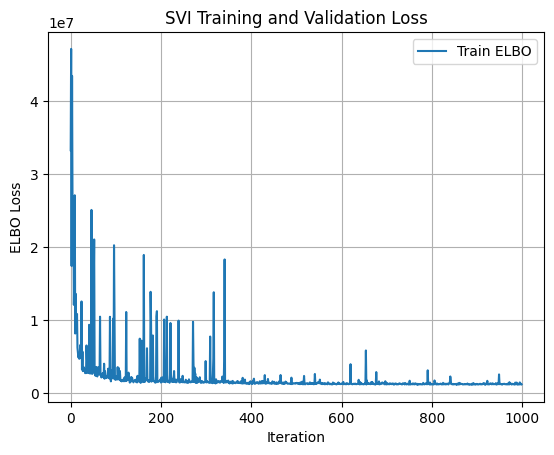

In [20]:
import matplotlib.pyplot as plt
plt.plot(losses, label="Train ELBO")
plt.xlabel('Iteration')
plt.ylabel('ELBO Loss')
plt.title('SVI Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Prediction

In [21]:
def predict_next_month(data, model, guide, num_samples):
    predictive = Predictive(
        model=model,
        guide=guide,
        num_samples=num_samples,
        return_sites=["obs"]
    )

    occupation_idx = data["occupation_idx"]
    X_static = data["X_static"]
    X_dynamic = data["X_dynamic"]
    X_seasonal = data["X_seasonal"]
    X_time_trend = data["X_time_trend"]
    X_temporal = data["X_temporal"]
    X_spatial = data["X_spatial"]

    return predictive(occupation_idx, X_static, X_dynamic, X_seasonal,
                            X_time_trend, X_temporal, X_spatial)
    


next_data = load_and_prepare(next_month, static, dynamic, seasonal_features,
                             time_features, temporal_features, dynamic_spatial)

prediction_samples = predict_next_month(next_data, burglary_model, guide, num_samples=1000)

In [22]:
def evaluate_coverage(prediction_samples, data):

    actual = data["burglaries"].values  # shape (N,)

    levels = np.arange(0, 1.00, 0.05)

    coverages = []   # will store actual coverage at each level
    mean_widths = [] # will store mean CI width at each level


    num_draws = prediction_samples["obs"].shape[0]  # e.g. 1000

    for lvl in levels:
        # Compute the index for the lower and upper quantiles in [0 .. num_draws-1]
        lower_q = int(np.floor(((1 - lvl) / 2) * num_draws))
        upper_q = int(np.ceil((1 - (1 - lvl) / 2) * num_draws)) - 1
        
        # Gather the samples at those quantile indices for each location
        lower_vals = prediction_samples["obs"].kthvalue(lower_q, dim=0).values.cpu().numpy()
        upper_vals = prediction_samples["obs"].kthvalue(upper_q, dim=0).values.cpu().numpy()
        
        # Compute coverage: fraction of actual counts within [lower_vals, upper_vals]
        coverage = np.mean((actual >= lower_vals) & (actual <= upper_vals))
        coverages.append(coverage)
        
        # Compute mean confidence‐interval width
        mean_width = np.mean(upper_vals - lower_vals)
        mean_widths.append(mean_width)

    level_perc = [lvl * 100 for lvl in levels]           
    coverage_perc = [cov * 100 for cov in coverages]          
    mean_widths = np.array(mean_widths) 

    plt.figure(figsize=(8, 5))

    # Use 'c=mean_widths' to color‐code by CI width, and 'cmap' to choose a colormap
    scatter = plt.scatter(
        coverage_perc, 
        level_perc,              
        s=80,                  
        c=mean_widths,             
        cmap='viridis',   
        edgecolor='black',         
        alpha=0.8                  
    )

    # Add a colorbar to show mapping from color to CI width
    cbar = plt.colorbar(scatter)
    cbar.set_label("Mean CI Width", fontsize=11)           
    plt.xlabel("Actual Coverage (%)", fontsize=12)              	
    plt.ylabel("Nominal Confidence Level (%)", fontsize=12)      	
    plt.title("Coverage vs. Confidence Level (Colored by Mean CI Width)", fontsize=14) 	
    plt.grid(alpha=0.3) 
    plt.tight_layout()           


# Parameter testing

In [23]:
# 1) Use Predictive with num_samples=2000 (or more) to approximate posterior
factors = [
        "b_static", "b_dynamic",
        "b_seasonal", "b_time_tr",
        "b_temporal", "b_spatial"
    ]
factors_map ={
    "b_static": static,
    "b_dynamic": dynamic,
    "b_seasonal": seasonal_features,
    "b_time_tr": time_features,
    "b_temporal": temporal_features,
    "b_spatial": dynamic_spatial,
}


def get_posterior_samples(data, model, guide, num_samples, factors_map):
    occupation_idx = data["occupation_idx"]
    X_static = data["X_static"]
    X_dynamic = data["X_dynamic"]
    X_seasonal = data["X_seasonal"]
    X_time_trend = data["X_time_trend"]
    X_temporal = data["X_temporal"]
    X_spatial = data["X_spatial"]

    return Predictive(
        model=model,
        guide=guide,
        num_samples=num_samples,
        return_sites=list(factors_map.keys())
    )(occupation_idx, X_static, X_dynamic, X_seasonal, X_time_trend, X_temporal, X_spatial)


posterior_samples = get_posterior_samples(next_data, burglary_model, guide, num_samples=2000, factors_map=factors_map)

In [24]:
def evaluate_factors(posterior_samples, factors, factors_map):
    for factor in factors:
        b_seasonal_samples = posterior_samples[factor]  # shape: (n_samples, 1, n_cols) or (n_samples, n_cols)

        # 1) Compute posterior mean, std, and 95% credible intervals
        mean_b_seasonal  = b_seasonal_samples.mean(dim=0)
        std_b_seasonal   = b_seasonal_samples.std(dim=0)
        lower_b_seasonal = torch.quantile(b_seasonal_samples, 0.025, dim=0)
        upper_b_seasonal = torch.quantile(b_seasonal_samples, 0.975, dim=0)

        # 2) Compute two‐sided Bayesian “p‐value” = 2 * min(P(β>0), P(β<0))
        prop_pos    = (b_seasonal_samples > 0.0).float().mean(dim=0)
        prop_neg    = (b_seasonal_samples < 0.0).float().mean(dim=0)
        p_val_tensor = 2.0 * torch.minimum(prop_pos, prop_neg)

        # 3) Collect rows into a list, including a “significant_CI” flag
        rows = []
        for j, col in enumerate(factors_map[factor]):
            mean_val   = mean_b_seasonal[0][j].item()
            lower_val  = lower_b_seasonal[0][j].item()
            upper_val  = upper_b_seasonal[0][j].item()
            p_val      = p_val_tensor[0][j].item()
            sig_ci     = (lower_val > 0.0) or (upper_val < 0.0)

            rows.append({
                "col": col,
                "mean": mean_val,
                "ci_lower": lower_val,
                "ci_upper": upper_val,
                "p_val": p_val,
                "significant_CI": sig_ci
            })

        # 4) Sort rows by p_val ascending (most significant first)
        rows_sorted = sorted(rows, key=lambda r: r["p_val"])

        # 5) Print in sorted order, including the “significant_CI” flag
        print(f"=== Factor: {factor} (sorted by p‐value) ===\n")
        for r in rows_sorted:
            print(
                f"{r['col']}:\n"
                f"  mean = {r['mean']:.4f}\n"
                f"  95% CI = [{r['ci_lower']:.4f}, {r['ci_upper']:.4f}]\n"
                f"  p_value ≈ {r['p_val']:.4f}\n"
                f"  significant_CI = {'Yes' if r['significant_CI'] else 'No'}\n"
            )
        print("\n")

evaluate_factors(posterior_samples, factors, factors_map)

=== Factor: b_static (sorted by p‐value) ===

Car or van availability|3 cars or vans in household (%):
  mean = 0.2590
  95% CI = [0.1972, 0.3233]
  p_value ≈ 0.0000
  significant_CI = Yes

Car or van availability|Cars per household:
  mean = 0.3796
  95% CI = [0.2952, 0.4632]
  p_value ≈ 0.0000
  significant_CI = Yes

Emergency locations:
  mean = 0.0439
  95% CI = [0.0265, 0.0605]
  p_value ≈ 0.0000
  significant_CI = Yes

Ethnic Group|Asian/Asian British (%):
  mean = 0.3469
  95% CI = [0.3064, 0.3907]
  p_value ≈ 0.0000
  significant_CI = Yes

Ethnic Group|BAME (%):
  mean = -0.6150
  95% CI = [-0.6697, -0.5602]
  p_value ≈ 0.0000
  significant_CI = Yes

Ethnic Group|Black/African/Caribbean/Black British (%):
  mean = 0.2692
  95% CI = [0.2170, 0.3205]
  p_value ≈ 0.0000
  significant_CI = Yes

Ethnic Group|Mixed/multiple ethnic groups (%):
  mean = 0.1693
  95% CI = [0.1251, 0.2131]
  p_value ≈ 0.0000
  significant_CI = Yes

Ethnic Group|Other ethnic group (%):
  mean = 0.0747
  9